In [1]:
import os
import PIL
import glob
import time
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as pt

from IPython import display
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.5.0-dev20210130'

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

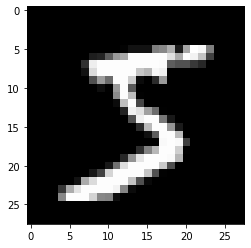

In [6]:
pt.imshow(train_images[0], cmap='gray')

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [8]:
def normalize_images(images):
    """
    Normalize the images to [-1, 1]
    """
    return (images - 127.5) / 127.5

In [9]:
train_images = normalize_images(train_images)
test_images = normalize_images(test_images)

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the Generator Model

In [12]:

class Autoencoder(tf.keras.models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.latent_dim=128
        self.encoder = self.make_encoder_model()
        self.decoder = self.make_decoder_model()
    
    def call(self, x, training: bool = None):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return encoded, decoded
    
    def make_encoder_model(self):
        inp = layers.Input(shape=(28*28,))
        x = layers.Dense(14*14*124, use_bias=False)(inp)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Reshape((14, 14, 124))(x)
        assert tuple(x.get_shape()) == (None, 14, 14, 124)

        x = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 14, 14, 64)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        y = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
        assert tuple(y.get_shape()) == (None, 14, 14, 64)
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        y = layers.Add()([x, y])

        y = layers.MaxPool2D((2, 2))(y)

        y = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(y)
        assert tuple(y.get_shape()) == (None, 4, 4, 32)
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        z = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', use_bias=False)(y)
        assert tuple(z.get_shape()) == (None, 4, 4, 32)
        z = layers.BatchNormalization()(z)
        z = layers.LeakyReLU()(z)

        z = layers.Add()([y, z])

        z = layers.Conv2D(8, (5, 5), strides=(1, 1), padding='same', use_bias=False)(z)
        z = layers.BatchNormalization()(z)
        z = layers.LeakyReLU()(z)

        z = layers.Dropout(0.3)(z)
        z = layers.Flatten()(z)
        assert tuple(z.get_shape()) == (None, 128)

        z = layers.Dense(4*4*8, use_bias=False)(z)

        return tf.keras.models.Model(inputs=inp, outputs=z)

    def make_decoder_model(self):
        inp = layers.Input(shape=(4*4*8))

        x = layers.Reshape((4, 4, 8))(inp)
        x = layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 8, 8, 4)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 16, 16, 2)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 32, 32, 1)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Flatten()(x)

        x = layers.Dense(28*28, use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 784)
        x = layers.Reshape((28, 28, 1))(x)

        return tf.keras.models.Model(inputs=inp, outputs=x)

In [13]:
autoencoder = Autoencoder()

In [14]:
# generator.summary()

In [15]:
# tf.keras.utils.plot_model(generator, to_file="generator_architecture.png")

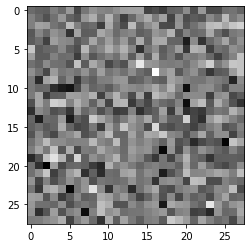

In [16]:
noise = tf.random.normal([1, 28*28])

pt.imshow(noise.numpy().reshape(28, 28), cmap='gray')

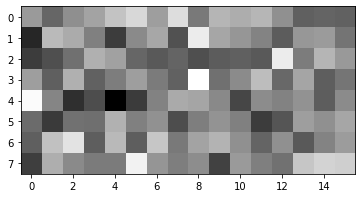

In [17]:
encoded_noise, decoded_noise = autoencoder(noise, training=False)

pt.imshow(encoded_noise.numpy().reshape(8, 16), cmap='gray')

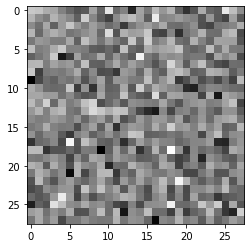

In [18]:
pt.imshow(decoded_noise.numpy()[0, :, :, 0], cmap='gray')

In [34]:
def make_discriminator_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(10, (5, 5), input_shape=(28, 28, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(10, (5, 5), padding='same')) # zero padding
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(10, (5, 5), padding='same')) # zero padding
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())

    model.add(layers.Dense(30))
    model.add(layers.LeakyReLU())

    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(1))
    
    return model

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(decoded_noise)
print(decision)

tf.Tensor([[-0.00030555]], shape=(1, 1), dtype=float32)


In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
mse = tf.keras.losses.MeanSquaredError()

In [23]:
def autoencoder_loss(image, decoded_image, encoded_image, encoded_decoded_image):
    decoder_loss =  mse(image, decoded_image)
    encoder_loss = cross_entropy(tf.ones_like(encoded_image), encoded_decoded_image)
    return decoder_loss + encoder_loss

In [24]:
def decoder_loss(image, decoded_image):
    return cross_entropy(tf.ones_like(image), decoded_image)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [26]:
def encoder_loss(image, decoded_image):
    return cross_entropy(tf.ones_like(image), decoded_image)

In [27]:
encoder_optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
decoder_optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
autoencoder_optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)

In [28]:
checkpoint_dir = './autoencoderGAN_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 autoencoder=autoencoder,
                                 discriminator=discriminator)

In [29]:
EPOCHS = 50
noise_dim = 28*28
num_examples_to_generate=9

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [30]:
@tf.function
def train_step(batch_length, images):
    noise = tf.random.normal([batch_length, noise_dim])
    
    with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as disc_tape:
        
        _, decoded_images = autoencoder(noise, training=True)
        encoded_decoded_images, _ = autoencoder(tf.reshape(decoded_images, noise.get_shape()), training=True)
        encoded_images, _ = autoencoder(tf.reshape(images, noise.get_shape()), training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(decoded_images, training=True)
        
        autoenc_loss = autoencoder_loss(images, decoded_images, encoded_images, encoded_decoded_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_autoencoder = autoencoder_tape.gradient(autoenc_loss, autoencoder.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [31]:
def generate_and_save_images(autoencoder, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    _, predictions = autoencoder(test_input, training=False)

    fig = pt.figure(figsize=(3, 3))

    for i in range(predictions.shape[0]):
        pt.subplot(3, 3, i+1)
        pt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        pt.axis('off')

    pt.savefig('autoencoder_image_at_epoch_{:04d}.png'.format(epoch))
    pt.show()

In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(len(image_batch), image_batch)
        
        # Produce images for the GIF every epoch
        display.clear_output(wait=True)
        generate_and_save_images(autoencoder,
                                    epoch+1,
                                    seed)
        
        # save the model every 15 epochs
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print(f'Time for epoch {epoch} is {time.time() - start}')
        
    # Generate an image after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(autoencoder, 
                                epochs,
                                seed)

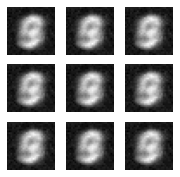

Time for epoch 22 is 23.36939573287964


KeyboardInterrupt: 

In [33]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using epoch number
def display_image(epoch_no):
    return PIL.Image.open('autoencoder_image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'adcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('autoencoder*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
noise = tf.random.normal([1, 100])
image = generator(noise, training=False)
pt.imshow(image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')